In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Objectif

Le Nutriscore est une information qui peut être utile pour comparer divers produits d'une même catégorie les uns avec les autres. Cependant, tous les produits ne disposent pas de cette information et il pourrait être intéressant de pouvoir calculer ce score à partir des indications disponibles sur les étiquettes des produits (ou même simplement en scannant le code-barre).

Nous allons donc essayer de calculer le nutriscore ou le nutrigrade en nous basant sur les données disponibles sur l'étiquette d'un produit.

#### Éléments défavorables au score

- Apport calorique pour cent grammes.
- Teneur en sucre.
- Teneur en graisses saturées.
- Teneur en sel.

#### Éléments favorables au score

- Teneur en fruits, légumes, légumineuses (dont les légumes secs), oléagineux, huiles de colza, de noix et d'olive.
- Teneur en fibres.
- Teneur en protéines.

Pour calculer la teneur de fruits et légumes, les féculents (tel que pomme de terre, patate douce, taro, manioc et tapioca) ne sont pas pris en compte.

Pour les fromages, la teneur en protéines est toujours prise en compte car celle-ci est liée à celle en calcium. Ceci améliore le nutri-score des fromages et la cohérence entre celui-ci et les recommandations nutritionnelles du Haut Conseil de la Santé Publique. Celles-ci recommandent en effet de consommer des produits laitiers plusieurs fois par jour. 

# Le jeu de données

> **A FAIRE**

Le jeu de données complet fait plus de 5.9GB. Et il est difficile de travailler avec un tel volume de donnée, donc je vais l'explorer petit à petit (d'abord la première ligne, puis ensuite en calculant le taux de remplissage petit bout par petit bout pour pouvoir charger un dataset allégé).

In [2]:
filename = 'data/en.openfoodfacts.org.products.csv'

#### Affichons uniquement la première ligne

In [3]:
prob = pd.read_csv(filename, sep='\t', low_memory=True, nrows=1)
prob

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16T14:53:28Z,1623855209,2021-06-16T14:53:29Z,jeunes pousses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Regardons l'ensemble des colonnes présentes *(et leur index pour pouvoir ajuster leur type en cas de mixed-type)*

In [4]:
for i, col in enumerate(prob.columns):
    print(i, col)

0 code
1 url
2 creator
3 created_t
4 created_datetime
5 last_modified_t
6 last_modified_datetime
7 product_name
8 abbreviated_product_name
9 generic_name
10 quantity
11 packaging
12 packaging_tags
13 packaging_en
14 packaging_text
15 brands
16 brands_tags
17 categories
18 categories_tags
19 categories_en
20 origins
21 origins_tags
22 origins_en
23 manufacturing_places
24 manufacturing_places_tags
25 labels
26 labels_tags
27 labels_en
28 emb_codes
29 emb_codes_tags
30 first_packaging_code_geo
31 cities
32 cities_tags
33 purchase_places
34 stores
35 countries
36 countries_tags
37 countries_en
38 ingredients_text
39 ingredients_tags
40 allergens
41 allergens_en
42 traces
43 traces_tags
44 traces_en
45 serving_size
46 serving_quantity
47 no_nutriments
48 additives_n
49 additives
50 additives_tags
51 additives_en
52 nutriscore_score
53 nutriscore_grade
54 nova_group
55 pnns_groups_1
56 pnns_groups_2
57 food_groups
58 food_groups_tags
59 food_groups_en
60 states
61 states_tags
62 states_en
6

#### Chargeons le CSV par petit bouts pour en calculer le `taux de remplissage` puis identifier les colonnes vides ou presque vides.

Nous allons également fournir les types pour les colonnes dont pandas n'est pas certain.

In [5]:
dtypes = {
    'code': 'str',
    'abbreviated_product_name': 'str',
    'packaging_text': 'str',
    'emb_codes': 'str',
    'emb_codes_tags': 'str',
    'first_packaging_code_geo': 'str',
    'cities_tags': 'str',
    'origins': 'str',
    'origins_tags': 'str',
    'origins_en': 'str',
    'manufacturing_places': 'str',
    'manufacturing_places_tags': 'str',
    'brand_owner': 'str',
    'generic_name': 'str',
    'packaging': 'str',
    'packaging_tags': 'str',
    'packaging_en': 'str',
    'labels': 'str',
    'labels_tags': 'str',
    'labels_en': 'str',
    'purchase_places': 'str',
    'stores': 'str',
    'allergens': 'str',
    'traces': 'str',
    'traces_tags': 'str',
    'traces_en': 'str',
    'serving_size': 'str',
    'additives_tags': 'str',
    'additives_en': 'str',
    'nutriscore_grade': 'str', # /!\
    'image_url': 'str',
    'image_small_url': 'str',
    'image_ingredients_url': 'str',
    'image_ingredients_small_url': 'str',
    'image_nutrition_url': 'str',
    'image_nutrition_small_url': 'str',
    'alcohol_100g': 'float',
}

chunksize = 10000
nan_rates = []
for chunk in pd.read_csv(filename, chunksize=chunksize, sep='\t', low_memory=True, dtype=dtypes):
    nan_rates.append(chunk.notna().mean(axis=0))

On fait la moyenne des taux calculés sur tous les chunks

In [6]:
inds_nan_rate = pd.concat(nan_rates, axis=1).mean(axis=1)

Et on l'affiche sous forme de graphique pour avoir une première idée du remplissage du dataset complet

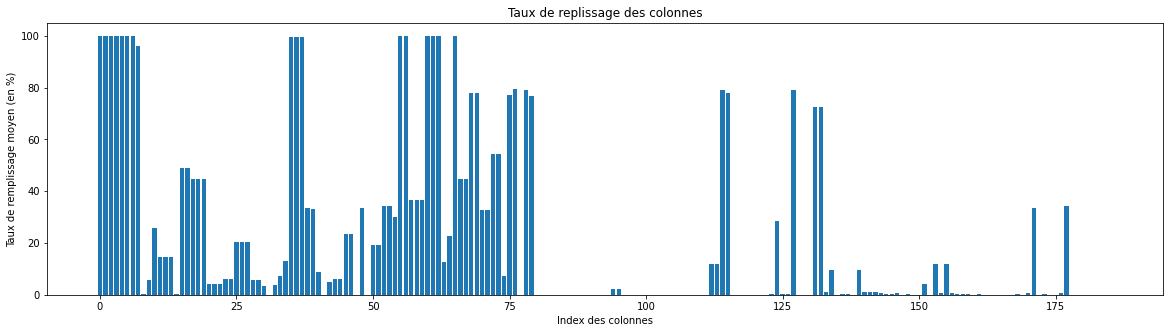

In [7]:
fig = plt.figure(figsize=(20,5))
plt.bar(range(0,len(inds_nan_rate)), inds_nan_rate*100)
plt.title("Taux de replissage des colonnes")
plt.xlabel("Index des colonnes")
plt.ylabel("Taux de remplissage moyen (en %)")
plt.show()

#### Supprimons les colonnes qui n'ont pas ou peu d'information sur lesquelles travailler

Commençons par regarder les colonnes complètement vides.

In [8]:
cols_fillrate_00 = inds_nan_rate[inds_nan_rate == 0.00].index
cols_fillrate_00, len(cols_fillrate_00)

(Index(['cities', 'allergens_en', 'no_nutriments', 'additives',
        '-butyric-acid_100g', '-caproic-acid_100g', '-caprylic-acid_100g',
        '-capric-acid_100g', '-lauric-acid_100g', '-myristic-acid_100g',
        '-palmitic-acid_100g', '-stearic-acid_100g', '-arachidic-acid_100g',
        '-behenic-acid_100g', '-lignoceric-acid_100g', '-cerotic-acid_100g',
        '-montanic-acid_100g', '-melissic-acid_100g',
        '-alpha-linolenic-acid_100g', '-eicosapentaenoic-acid_100g',
        '-docosahexaenoic-acid_100g', '-linoleic-acid_100g',
        '-arachidonic-acid_100g', '-gamma-linolenic-acid_100g',
        '-dihomo-gamma-linolenic-acid_100g', '-oleic-acid_100g',
        '-elaidic-acid_100g', '-gondoic-acid_100g', '-mead-acid_100g',
        '-erucic-acid_100g', '-nervonic-acid_100g', '-sucrose_100g',
        '-glucose_100g', '-fructose_100g', '-lactose_100g', '-maltose_100g',
        '-maltodextrins_100g'],
       dtype='object'),
 37)

Partons du principe que l'on retire toutes les colonnes dont le taux de remplissage est ingérieur à 5%. Nous allons ensuite étudier la pertinence de ce choix.

In [9]:
cols_to_remove = inds_nan_rate[inds_nan_rate < 0.05].index
cols_to_remove, len(cols_to_remove)

(Index(['abbreviated_product_name', 'packaging_text', 'origins', 'origins_tags',
        'origins_en', 'first_packaging_code_geo', 'cities', 'cities_tags',
        'allergens_en', 'traces',
        ...
        'carbon-footprint_100g', 'carbon-footprint-from-meat-or-fish_100g',
        'nutrition-score-uk_100g', 'glycemic-index_100g', 'water-hardness_100g',
        'choline_100g', 'phylloquinone_100g', 'beta-glucan_100g',
        'inositol_100g', 'carnitine_100g'],
       dtype='object', length=105),
 105)

In [10]:
for i, col_name in enumerate(cols_to_remove):
    print(i, col_name)

0 abbreviated_product_name
1 packaging_text
2 origins
3 origins_tags
4 origins_en
5 first_packaging_code_geo
6 cities
7 cities_tags
8 allergens_en
9 traces
10 no_nutriments
11 additives
12 energy-from-fat_100g
13 -butyric-acid_100g
14 -caproic-acid_100g
15 -caprylic-acid_100g
16 -capric-acid_100g
17 -lauric-acid_100g
18 -myristic-acid_100g
19 -palmitic-acid_100g
20 -stearic-acid_100g
21 -arachidic-acid_100g
22 -behenic-acid_100g
23 -lignoceric-acid_100g
24 -cerotic-acid_100g
25 -montanic-acid_100g
26 -melissic-acid_100g
27 monounsaturated-fat_100g
28 polyunsaturated-fat_100g
29 omega-3-fat_100g
30 -alpha-linolenic-acid_100g
31 -eicosapentaenoic-acid_100g
32 -docosahexaenoic-acid_100g
33 omega-6-fat_100g
34 -linoleic-acid_100g
35 -arachidonic-acid_100g
36 -gamma-linolenic-acid_100g
37 -dihomo-gamma-linolenic-acid_100g
38 omega-9-fat_100g
39 -oleic-acid_100g
40 -elaidic-acid_100g
41 -gondoic-acid_100g
42 -mead-acid_100g
43 -erucic-acid_100g
44 -nervonic-acid_100g
45 -sucrose_100g
46 -glu

> Donc si on supprime les colonnes qui ont un taux de remplissage inférieur à 5%, on allège le jeu de données de 134 colonnes.
> 
> Ce qui le porterait de 186 à 81 colonnes.

#### Appliquons cette réduction et voyons si un tel jeu de données pourrait être utile.

In [11]:
cols_to_load = set(prob.columns) - set(cols_to_remove)
cols_to_load

{'additives_en',
 'additives_n',
 'additives_tags',
 'allergens',
 'brand_owner',
 'brands',
 'brands_tags',
 'calcium_100g',
 'carbohydrates_100g',
 'categories',
 'categories_en',
 'categories_tags',
 'cholesterol_100g',
 'code',
 'countries',
 'countries_en',
 'countries_tags',
 'created_datetime',
 'created_t',
 'creator',
 'ecoscore_grade',
 'ecoscore_score',
 'emb_codes',
 'emb_codes_tags',
 'energy-kcal_100g',
 'energy-kj_100g',
 'energy_100g',
 'fat_100g',
 'fiber_100g',
 'food_groups',
 'food_groups_en',
 'food_groups_tags',
 'fruits-vegetables-nuts-estimate-from-ingredients_100g',
 'generic_name',
 'image_ingredients_small_url',
 'image_ingredients_url',
 'image_nutrition_small_url',
 'image_nutrition_url',
 'image_small_url',
 'image_url',
 'ingredients_tags',
 'ingredients_text',
 'iron_100g',
 'labels',
 'labels_en',
 'labels_tags',
 'last_modified_datetime',
 'last_modified_t',
 'main_category',
 'main_category_en',
 'manufacturing_places',
 'manufacturing_places_tags',
 

In [12]:
data = pd.read_csv(filename, sep='\t', dtype=dtypes, usecols=cols_to_load)

# Explorons le jeu de données reduit

In [13]:
data.shape

(2251894, 81)

In [14]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [15]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
created_t,2251894.000,1569699848.860,56376500.302,1328021038.000,1531032572.750,1580396622.500,1616668215.500,1649120011.000
last_modified_t,2251894.000,1609588517.537,33254597.947,1353581570.000,1587596543.000,1616697959.000,1640118476.750,1649120881.000
serving_quantity,526776.000,21092745435793836.000,15308918127999203328.000,0.000,28.000,55.000,114.000,11111111111111100858368.000
additives_n,755169.000,2.013,2.880,0.000,0.000,1.000,3.000,49.000
nutriscore_score,776383.000,9.091,8.849,-15.000,1.000,10.000,16.000,40.000
nova_group,679561.000,3.382,0.992,1.000,3.000,4.000,4.000,4.000
ecoscore_score,516814.000,43.546,25.704,-30.000,27.000,39.000,65.000,125.000
energy-kj_100g,162957.000,40903789888675473637899005574841892864.000,16512014422283680237661674859037450043392.000,0.000,394.000,980.000,1619.000,6665558888888888950360610417759390841962496.000
energy-kcal_100g,1737339.000,62672267.876,76154079787.096,0.000,100.000,259.000,400.000,100000000376832.000
energy_100g,1786722.000,3730607721228534090965745911682039808.000,4986640698625920150338062244302641168384.000,0.000,418.000,1079.000,1674.000,6665558888888888950360610417759390841962496.000


In [16]:
data.describe(exclude="number").T

,count,unique,top,freq
code,2251894,2251873,2700963001059,2
url,2251894,2251876,http://world-en.openfoodfacts.org/product/2999...,2
creator,2251890,15711,kiliweb,1351818
created_datetime,2251894,1997076,2020-04-23T17:22:07Z,28
last_modified_datetime,2251894,1644399,2021-09-02T17:25:05Z,193
product_name,2166180,1387469,Miel,1449
generic_name,127050,91839,Pâtes alimentaires de qualité supérieure,302
quantity,576236,39373,500 g,24211
packaging,333760,44601,Plastique,11380
packaging_tags,333751,39144,en:plastic,39417


#### Affichons les valeurs manquantes pour chaque colonne

<AxesSubplot:>

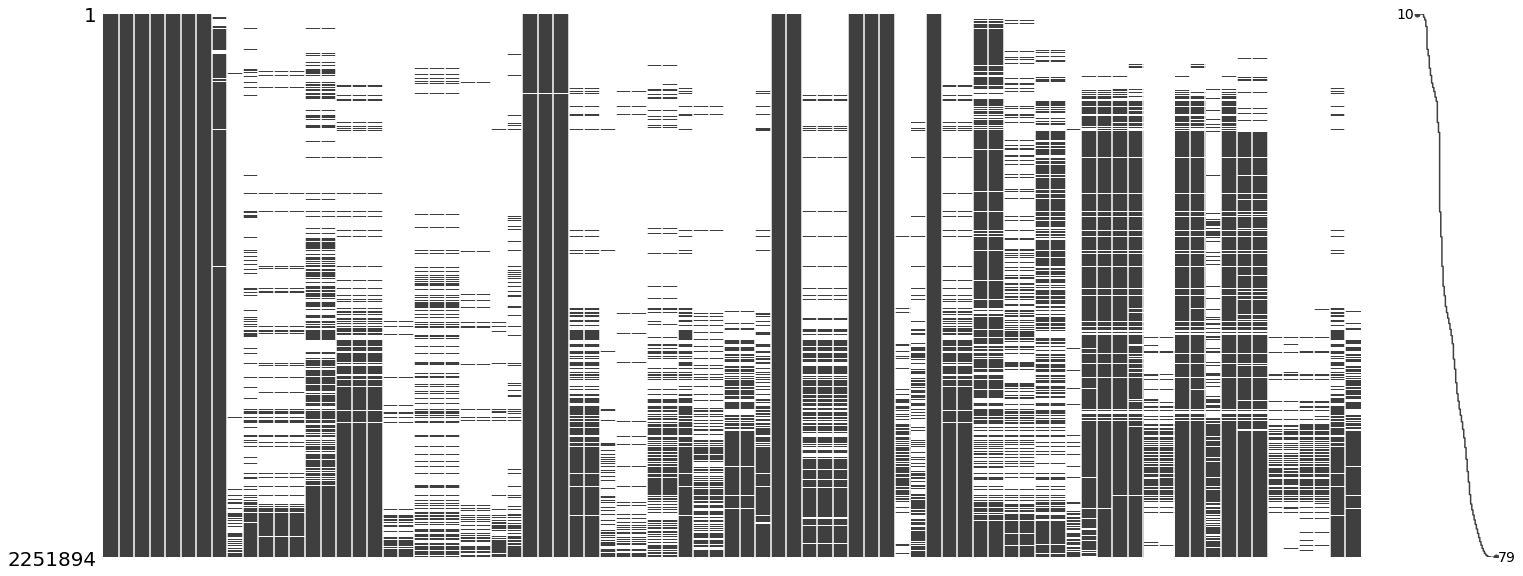

In [17]:
import missingno as msno
msno.matrix(data, sort="ascending")

> Visiblement, même allégé des colonnes les plus vides, ce jeu de données présente encore beaucoup de trous.

#### Affichons les taux de valeurs manquantes pour chaque colonne.

In [18]:
# Définissons une fonction qui nous permet d'afficher 
# facilement le nombre de valeurs manquantes et leur taux

def print_missing_counts(dataset, col_array):
    missing_count = dataset[col_array].isnull().sum()
    missing_ratio = missing_count/dataset.shape[0]*100.0
    
    for k, v in zip(missing_count.keys(), missing_count):
        fraction = v/dataset.shape[0]*100.0
        print(f"{k.rjust(30)} is missing {v:10} values \t -->   {fraction:6.2f}%")
    return missing_ratio

In [19]:
missing_ratio = print_missing_counts(data, data.columns)

                          code is missing          0 values 	 -->     0.00%
                           url is missing          0 values 	 -->     0.00%
                       creator is missing          4 values 	 -->     0.00%
                     created_t is missing          0 values 	 -->     0.00%
              created_datetime is missing          0 values 	 -->     0.00%
               last_modified_t is missing          0 values 	 -->     0.00%
        last_modified_datetime is missing          0 values 	 -->     0.00%
                  product_name is missing      85714 values 	 -->     3.81%
                  generic_name is missing    2124844 values 	 -->    94.36%
                      quantity is missing    1675658 values 	 -->    74.41%
                     packaging is missing    1918134 values 	 -->    85.18%
                packaging_tags is missing    1918143 values 	 -->    85.18%
                  packaging_en is missing    1918143 values 	 -->    85.18%
            

#### Supprimons les colonnes qui ne semblent pas présenter d'intérêt pour notre objectif tout en aillant un taux de remplissage assez bas.

On supprime les colonnes qui sont redondantes avec une autres, qui ne présentent pas d'intérêt (sans doute possible) pour prédire le Nutriscore, ou qui ne peuvent pas aider à retrouver le produit dans la base.

In [69]:
# Ceux mis en commentaire ne sont pas gardés

cols_useless = [
    #'code',
    #'url', 
    'creator', 
    #'created_t', 
    'created_datetime',
    #'last_modified_t',
    'last_modified_datetime', 
    #'product_name',
    'generic_name', 
    #'quantity', 
    'packaging', 
    'packaging_tags',
    'packaging_en', 
    'brands', 
    #'brands_tags', 
    'categories',
    #'categories_tags', 
    'categories_en', 
    'manufacturing_places',
    'manufacturing_places_tags', 
    'labels', 
    #'labels_tags', 
    'labels_en',
    'emb_codes', 
    #'emb_codes_tags', 
    'purchase_places', 
    #'stores', 
    'countries',
    #'countries_tags', 
    'countries_en', 
    'ingredients_text',
    #'ingredients_tags', 
    #'allergens', 
    #'traces_tags', 
    'traces_en',
    #'serving_size',
    #'serving_quantity', 
    #'additives_n', 
    #'additives_tags',
    'additives_en', 
    #'nutriscore_score', 
    #'nutriscore_grade', 
    #'nova_group',
    #'pnns_groups_1', 
    #'pnns_groups_2', 
    #'food_groups', 
    'food_groups_tags',
    'food_groups_en', 
    'states', 
    #'states_tags', 
    'states_en', 
    'brand_owner',
    #'ecoscore_score', # On pourrait aussi regarder pour calculer l'ecoscore
    #'ecoscore_grade', # On pourrait aussi regarder pour calculer l'ecograde
    #'main_category', 
    'main_category_en',
    'image_url', 
    'image_small_url', 
    'image_ingredients_url',
    'image_ingredients_small_url',
    'image_nutrition_url',
    'image_nutrition_small_url', 
    #'energy-kj_100g', 
    #'energy-kcal_100g',
    #'energy_100g', 
    #'fat_100g', 
    #'saturated-fat_100g', 
    #'trans-fat_100g',
    #'cholesterol_100g', 
    #'carbohydrates_100g', 
    #'sugars_100g', 
    #'fiber_100g',
    #'proteins_100g', 
    #'salt_100g', 
    #'sodium_100g', 
    #'vitamin-a_100g',
    #'vitamin-c_100g', 
    #'calcium_100g', 
    #'iron_100g',
    #'fruits-vegetables-nuts-estimate-from-ingredients_100g',
    #'nutrition-score-fr_100g'
]

In [70]:
cols_to_load_mini = set(cols_to_load) - set(cols_useless)
cols_to_load_mini, len(cols_to_load_mini)

({'additives_n',
  'additives_tags',
  'allergens',
  'brands_tags',
  'calcium_100g',
  'carbohydrates_100g',
  'categories_tags',
  'cholesterol_100g',
  'code',
  'countries_tags',
  'created_t',
  'ecoscore_grade',
  'ecoscore_score',
  'emb_codes_tags',
  'energy-kcal_100g',
  'energy-kj_100g',
  'energy_100g',
  'fat_100g',
  'fiber_100g',
  'food_groups',
  'fruits-vegetables-nuts-estimate-from-ingredients_100g',
  'ingredients_tags',
  'iron_100g',
  'labels_tags',
  'last_modified_t',
  'main_category',
  'nova_group',
  'nutriscore_grade',
  'nutriscore_score',
  'nutrition-score-fr_100g',
  'pnns_groups_1',
  'pnns_groups_2',
  'product_name',
  'proteins_100g',
  'quantity',
  'salt_100g',
  'saturated-fat_100g',
  'serving_quantity',
  'serving_size',
  'sodium_100g',
  'states_tags',
  'stores',
  'sugars_100g',
  'traces_tags',
  'trans-fat_100g',
  'url',
  'vitamin-a_100g',
  'vitamin-c_100g'},
 48)

#### Préparons une copie du dataset qui ne contient que les colonnes retenues

In [87]:
data_clean = data[cols_to_load_mini]
data_clean.shape

(2251894, 48)

<AxesSubplot:>

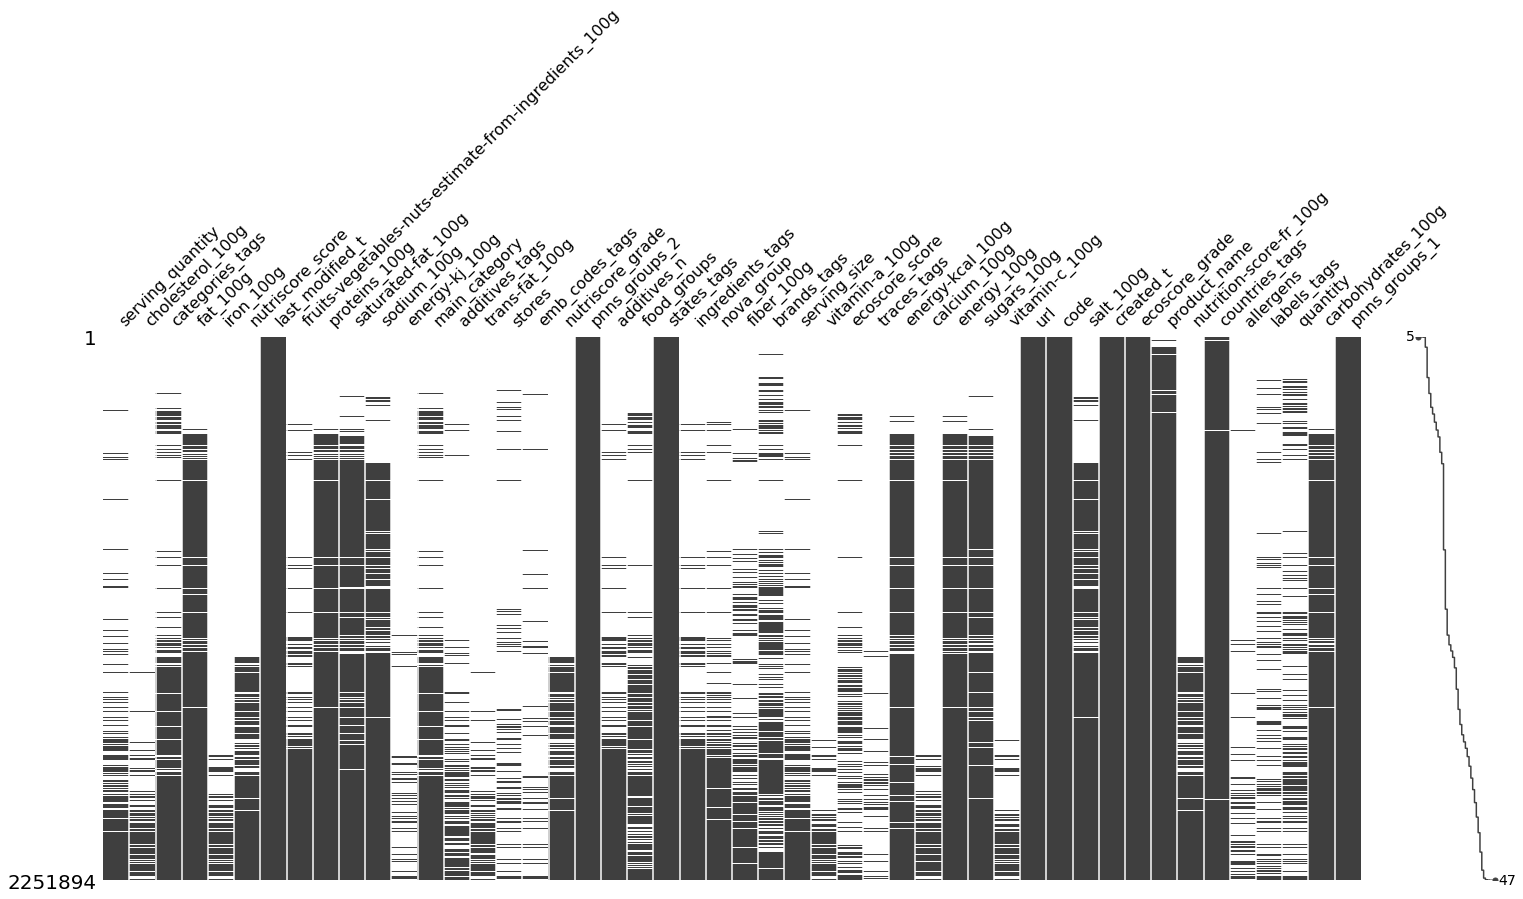

In [72]:
msno.matrix(data_clean, sort="ascending")

## Supprimons les doublons

In [88]:
data_duplicate = data_clean.copy()

#### Commençons par supprimer les produits en double sur la base du code-barre

In [89]:
duplicated = data_duplicate.code.duplicated(keep='first')
duplicated.sum()

21

In [90]:
data_duplicate.drop_duplicates(subset=['code'], inplace=True) 

> Nous avons donc supprimé 21 produits en double.

#### Ensuite vérifions si il y a des lignes similaires en excluant le code-barre et les dates

In [91]:
cols_without_code = list(data_duplicate.columns)
cols_without_code.remove("code")
cols_without_code.remove("created_t")
cols_without_code.remove("last_modified_t")

In [92]:
duplicated = data_duplicate[cols_without_code].duplicated(keep='first')
duplicated.sum()

0

> Il n'y a visiblement pasd'autres doublons.

#### Reportons les modifications sur le data_clean

In [93]:
data_clean = data_duplicate.copy()
data_clean.shape

(2251873, 48)

## Supprimons les valeurs aberrantes

In [95]:
data_clean.describe().T

,count,mean,std,min,25%,50%,75%,max
serving_quantity,526772.000,21092905601827232.000,15308976251396298752.000,0.000,28.000,55.000,114.000,11111111111111100858368.000
cholesterol_100g,269384.000,0.060,1.951,0.000,0.000,0.000,0.022,381.000
fat_100g,1777171.000,562758957893.806,750128029477957.875,0.000,0.800,7.000,21.200,1000000000000000000.000
iron_100g,265735.000,0.038,6.442,-0.000,0.000,0.001,0.002,1800.000
nutriscore_score,776372.000,9.091,8.848,-15.000,1.000,10.000,16.000,40.000
last_modified_t,2251873.000,1609588245.528,33254622.260,1353581570.000,1587596541.000,1616697587.000,1640118330.000,1649120881.000
fruits-vegetables-nuts-estimate-from-ingredients_100g,753804.000,8.602,36.118,0.000,0.000,0.000,0.500,13461.000
proteins_100g,1778595.000,56199.316,74932325.524,-500.000,1.300,6.000,12.500,99932728111.000
saturated-fat_100g,1731424.000,57722.781,75946196.215,0.000,0.100,1.800,7.000,99932728111.000
sodium_100g,1640236.000,24371.469,31211494.545,0.000,0.033,0.236,0.560,39973091244.400


Comme on peut le constater, un certain nombre de colonnes ont des valeurs étonnantes...

> `serving_quantity`
> 
> le maximum est bien au delà du troisième quartile, et l'écart type est énorme...

> `cholesterol_100g`, `fat_100g`, `iron_100g`, `fruits-vegetables-nuts-estimate-from-ingredients_100g`, `proteins_100g`, `saturated-fat_100g`, `sodium_100g`, `energy-kj_100g`, `trans-fat_100g`, `fiber_100g`, `vitamin-a_100g`, `energy-kcal_100g`, `calcium_100g`, `energy_100g`, `sugars_100g`, `vitamin-c_100g`, `salt_100g`, `carbohydrates_100g`
>
> le maximum dépasse les 100g et ce n'est pas possible *(car d'après la notice **"fields that end with _100g correspond to the amount of a nutriment (in g, or kJ for energy) for 100 g or 100 ml of product"** et donc il ne peut y avoir de valeurs > 100)*

> `nutriscore_score`, `proteins_100g`, `fiber_100g`, `ecoscore_score`, `sugars_100g`, `nutrition-score-fr_100g`, `carbohydrates_100g`
>
> le minimum est sous 0, ce qui ne semble pas cohérent avec l'intitulé de ces colonnes.

> Pour `cholesterol_100g` le maximum semble être à **3.1g** (3100mg) pour 100g /// Cervelle de veau cuite

> Pour `fat_100g` le maximum semble être à **100g** pour 100g /// Huile d'avocat

> Pour `saturated-fat_100g` le maximum semble être à **92.6** pour 100g /// Pain de friture (pas l'huile ?)

> Pour `proteins_100g` le maximum semble être à **87.6g** pour 100g /// Gélatine alimentaire

> Pour `sugars_100g` le maximum semble être à **99.8g** pour 100g /// Fructose

> Pour `carbohydrates_100g` le maximum semble être à **99.8g** pour 100g /// Fructose

> Pour `sodium_100g` le maximum semble être à **39.1g** (39100 mg)pour 100g /// sel blanc non iodé non fluoré 

> Pour `salt_100g` le maximum semble être à **39.1g** (39100 mg)pour 100g /// sel blanc non iodé non fluoré 

> Pour `iron_100g` le maximum semble être à **0,0064g** (6.4 mg) pour 100g /// Boudin noir

> Pour `calcium_100g` le maximum semble être à **2g** (2000 mg) pour 100g /// Meloukhia en poudre 

> Pour `fiber_100g` le maximum semble être à **43.5g** pour 100g /// Cannelle

> Pour `energy-kcal_100g` le maximum semble être à **900 kcal** pour 100g /// Huile d'avocat

> Pour `energy-kj_100g` le maximum semble être à **3765.6 kcal** pour 100g /// Huile d'avocat


# Notes & Essais

In [28]:
data.states

0          en:to-be-completed, en:nutrition-facts-to-be-c...
1          en:to-be-completed, en:nutrition-facts-complet...
2          en:to-be-completed, en:nutrition-facts-complet...
3          en:to-be-completed, en:nutrition-facts-to-be-c...
4          en:to-be-completed, en:nutrition-facts-complet...
                                 ...                        
2251889    en:to-be-completed, en:nutrition-facts-to-be-c...
2251890    en:to-be-completed, en:nutrition-facts-to-be-c...
2251891    en:to-be-completed, en:nutrition-facts-complet...
2251892    en:to-be-completed, en:nutrition-facts-complet...
2251893    en:to-be-completed, en:nutrition-facts-to-be-c...
Name: states, Length: 2251894, dtype: object

In [29]:
data.states.iat[0]

'en:to-be-completed, en:nutrition-facts-to-be-completed, en:ingredients-to-be-completed, en:expiration-date-to-be-completed, en:packaging-code-to-be-completed, en:characteristics-to-be-completed, en:origins-to-be-completed, en:categories-to-be-completed, en:brands-completed, en:packaging-to-be-completed, en:quantity-to-be-completed, en:product-name-completed, en:photos-to-be-uploaded'

In [ ]:
data.states_fr